## Pre Explanation

In this version I tried to use dummy encoding on column 'city', and dropped column 'city_development_index',
<br>as when I check the corr heatmap, 'city_development_index' cause multicollinearity problem with some other columns.
<br> The change in the results:
+ 1) For all models, score dropped significantly and even trained model with oversampling dataset, 
<br> the performance didn't get much better. LogisticRegression and GaussianNB are the only 2 models have acceptable 
<br> recall and roc_auc score, while the other models' score (recall) are all under 0.55.
+ 2) The feature importance ratio also changed, after I changed the encoding method to dummy encoding.
<br> In the case of model decision tree, random forest, xgb and lightgb, the 9th feature which is 'training time' became the most important feature,while other models, cities have high ratio of positive classes are the most important feature, such as city21, city16 etc.

## Imports & Setup

In [206]:
import os
import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
#from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [207]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone
/Users/liuyang/Desktop/Springboard_Capstone


In [208]:
df = pd.read_csv('data/preprocessed_train.csv')

In [209]:
df.head()

city  city_development_index  gender  relevent_experience  \
0  city_149                   0.689       1                    1   
1   city_83                   0.923       1                    1   
2   city_16                   0.910       1                    1   
3   city_64                   0.666       1                    1   
4  city_100                   0.887       1                    0   

   enrolled_university  education_level  major_discipline  experience  \
0                    0                2                 1           1   
1                    0                2                 1           3   
2                    0                2                 1           2   
3                    0                2                 1           3   
4                    0                2                 1           2   

   company_size  company_type  last_new_job  training_hours  target  
0             2             4             1             106       0  
1             1             2             1              69       0  
2             1             1             1               4       0  
3             1             4             1              26       0  
4             1             4             1              88       1

In [210]:
df.shape

(18359, 13)

In [211]:
# check the how many city we have in the dataset.
len(df.city.unique())

48

In [212]:
# dummy encode 'city' column and drop 'city' column in the original df together with 'city_development_index' due to multicollinearity
city_dummy = pd.get_dummies(df.city)

df = pd.concat([df.drop(['city','city_development_index'],axis=1),city_dummy], axis=1)

In [215]:
# df columns increased from 13 to 59. (13 + 48 -2)
df.shape

(18359, 59)

In [214]:
df.head()

gender  relevent_experience  enrolled_university  education_level  \
0       1                    1                    0                2   
1       1                    1                    0                2   
2       1                    1                    0                2   
3       1                    1                    0                2   
4       1                    0                    0                2   

   major_discipline  experience  company_size  company_type  last_new_job  \
0                 1           1             2             4             1   
1                 1           3             1             2             1   
2                 1           2             1             1             1   
3                 1           3             1             4             1   
4                 1           2             1             4             1   

   training_hours  ...  city_71  city_73  city_74  city_75  city_83  city_89  \
0             106  ...        0        0        0        0        0        0   
1              69  ...        0        0        0        0        1        0   
2               4  ...        0        0        0        0        0        0   
3              26  ...        0        0        0        0        0        0   
4              88  ...        0        0        0        0        0        0   

   city_90  city_97  city_98  city_99  
0        0        0        0        0  
1        0        0        0        0  
2        0        0        0        0  
3        0        0        0        0  
4        0        0        0        0  

[5 rows x 59 columns]

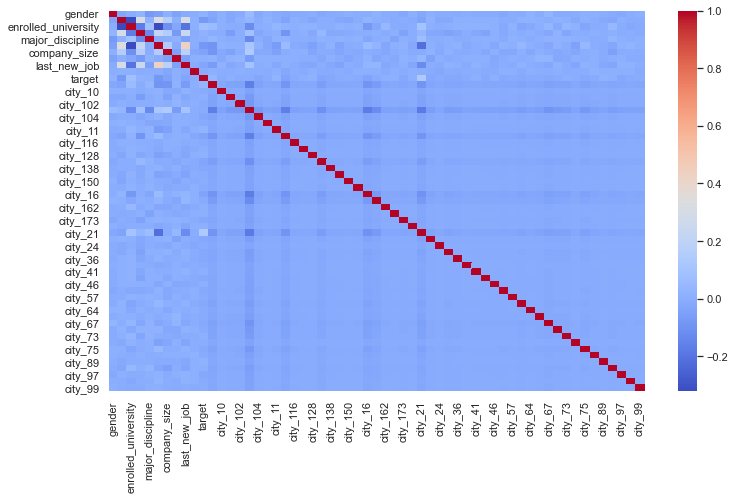

In [127]:
# plot heatmap make sure no more multicollinearity exists 

_= plt.subplots(figsize=(12,7))
sns.heatmap(df.corr(),cmap='coolwarm') 
plt.show()

In [128]:
X = df.drop(['target'],axis=1)
y = df['target'].ravel()

## Encode 'city' column via LeaveOneOutEncoder

In [129]:
# Scale X 
X_scaled = StandardScaler().fit_transform(X)

In [130]:
# Split train test set
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=43)

In [131]:
# Confirm there's positive class in the test set.
np.unique(y_test,return_counts=True)

(array([0, 1]), array([4780,  728]))

In [132]:
# Check how imbalanced the data is in y_train.
np.unique(y_train, return_counts=True)[1][0]/np.unique(y_train, return_counts=True)[1][1]

6.572775486152033

we can see in our y_train, the ratio between negative and positive classes are 6.6 : 1 
This class imbalance may cause some negative effect when we train the model.
As our models look at the data and cleverly decide that the best thing to do is to always predict negative class and achieve high accuracy.
If that happens we will normally get high accuracy but low recall or sometimes even zero recall, precision as the model will only predict negative class.

## Train Models with Defaul Settings

### Select Models

In [133]:
index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']
models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=43),
          DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

    # combine index and models to a dictionary
model_dict = dict(zip(index,models))

In [134]:
# cv before oversampling

def model_eval(model_name, X, y, n):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=n)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
    
    return pd.DataFrame(model_res).round(3)

In [97]:
# create a function to collect all test scores for all the models before oversampling
def allmodel_perform(X, y, n):
    # create a empty list to put the average model test_score from the validation
    model_score_average = []
    
    # Loop inside the model_dict and average the test_score. (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
    # Append the avarage score to list 'model_score_average' 
    for model in model_dict.values():
        model_score_average.append(model_eval(model,X,y,n).mean())


    # put the model_score_average into a dataframe 
    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dict.keys())).round(5)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

In [135]:
# plot test result for all models
model_res = allmodel_perform(X_train, y_train, 5)
model_res

/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_cl

model  fit_time  score_time  test_accuracy  test_precision  test_recall  \
0       LR    0.0186      0.0064         0.8676          0.0000       0.0000   
1      GNB    0.0112      0.0102         0.5030          0.1664       0.6854   
2      KNN    0.1406      2.6344         0.8510          0.2484       0.0622   
3      SVC   22.6432      1.1976         0.8678          0.0000       0.0000   
4       DT    0.0580      0.0060         0.7712          0.1642       0.1782   
5       RF    0.9666      0.1170         0.8366          0.2174       0.0922   
6       GB    1.1480      0.0116         0.8672          0.1900       0.0018   
7      XGB    0.7770      0.0140         0.8626          0.2528       0.0200   
8  LightGB    0.1380      0.0154         0.8668          0.2138       0.0036   

   test_f1_score  test_roc_auc  
0         0.0000        0.6380  
1         0.2678        0.6128  
2         0.0992        0.5654  
3         0.0000        0.5390  
4         0.1706        0.5224  
5         0.1288        0.5676  
6         0.0034        0.6346  
7         0.0370        0.6094  
8         0.0068        0.6188

In [136]:
# oversampling inside cross validation train_fold

def model_eval_os(model_name, n):
    
    precisions = []
    recalls = []
    f1scores = []
    aucs = []
    roc_aucs=[]
    y_proba = []
    y_pred = []
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        model = model_name
        
        model.fit(X_train_oversampled, y_train_oversampled)
        
        y_pred = model.predict(X_test_fold)
        y_pred_proba = model.predict_proba(X_test_fold)[:,1]
        
       
        recalls.append(recall_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        precisions.append(precision_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        f1scores.append(f1_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_proba))
        aucs.append(model.score(X_test_fold, y_test_fold))
        y_proba.append(y_pred_proba)
    
    res = pd.DataFrame([precisions,recalls,f1scores,aucs,roc_aucs]).T
    res.columns = ['test_precison', 'test_recall', 'test_f1score', 'test_accuracy', 'test_roc_auc']
    return res
    

In [137]:
def allmodel_perform_os(n):

    model_score_average = []

    for model in model_dict.values():
        model_score_average.append(model_eval_os(model,n).mean())

    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dict.keys())).round(5)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

In [138]:
# plot result after oversampling inside cv train dataset
model_res_os = allmodel_perform_os(5)
model_res_os

model  test_precison  test_recall  test_f1score  test_accuracy  \
0       LR        0.19771      0.55864       0.29197        0.64252   
1      GNB        0.14904      0.80520       0.25140        0.36597   
2      KNN        0.16324      0.39807       0.23127        0.65084   
3      SVC        0.19883      0.51287       0.28642        0.66283   
4       DT        0.16873      0.22212       0.19147        0.75200   
5       RF        0.19207      0.16967       0.17987        0.79558   
6       GB        0.27337      0.20198       0.23159        0.82321   
7      XGB        0.26298      0.14705       0.18823        0.83231   
8  LightGB        0.26266      0.18580       0.21708        0.82320   

   test_roc_auc  
0       0.63475  
1       0.60991  
2       0.56220  
3       0.62456  
4       0.52774  
5       0.56921  
6       0.61228  
7       0.60460  
8       0.61398

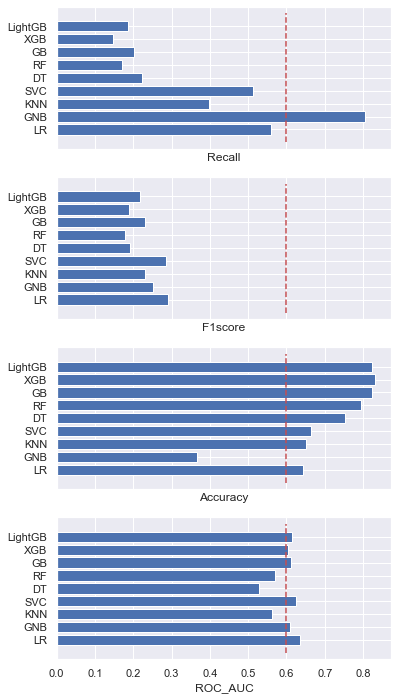

In [142]:
# plot barh plot to check the average score of recall, fscore, accuracy, roc_auc from cross validation
fig,axs = plt.subplots(4,1, figsize=(6,12),sharex=True)

axs[0].barh('model', 'test_recall', data=model_res_os)
axs[1].barh('model', 'test_f1score', data=model_res_os)
axs[2].barh('model', 'test_accuracy', data=model_res_os)
axs[3].barh('model', 'test_roc_auc',data=model_res_os)

axs[0].set_xlabel('Recall')
axs[1].set_xlabel('F1score')
axs[2].set_xlabel('Accuracy')
axs[3].set_xlabel('ROC_AUC')


axs[0].plot([0.6,0.6],[-1,9],'r--')
axs[1].plot([0.6,0.6],[-1,9],'r--')
axs[2].plot([0.6,0.6],[-1,9],'r--')
axs[3].plot([0.6,0.6],[-1,9],'r--')
plt.show()

<BarContainer object of 58 artists>

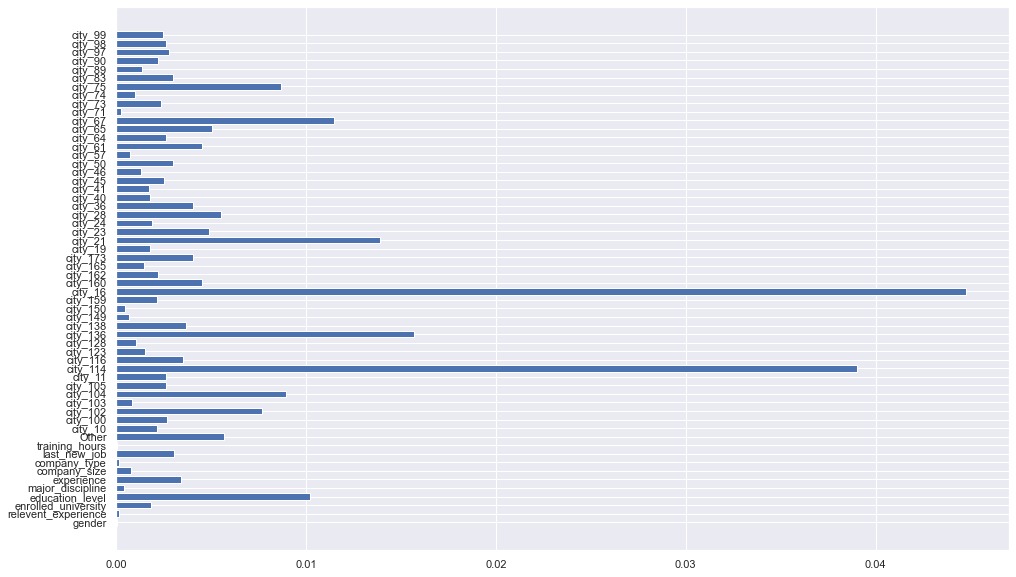

In [196]:
from sklearn.inspection import permutation_importance
model = GaussianNB()
model.fit(X_train, y_train)

imps = permutation_importance(model, X_train, y_train)
fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), abs(imps.importances_mean))

<BarContainer object of 58 artists>

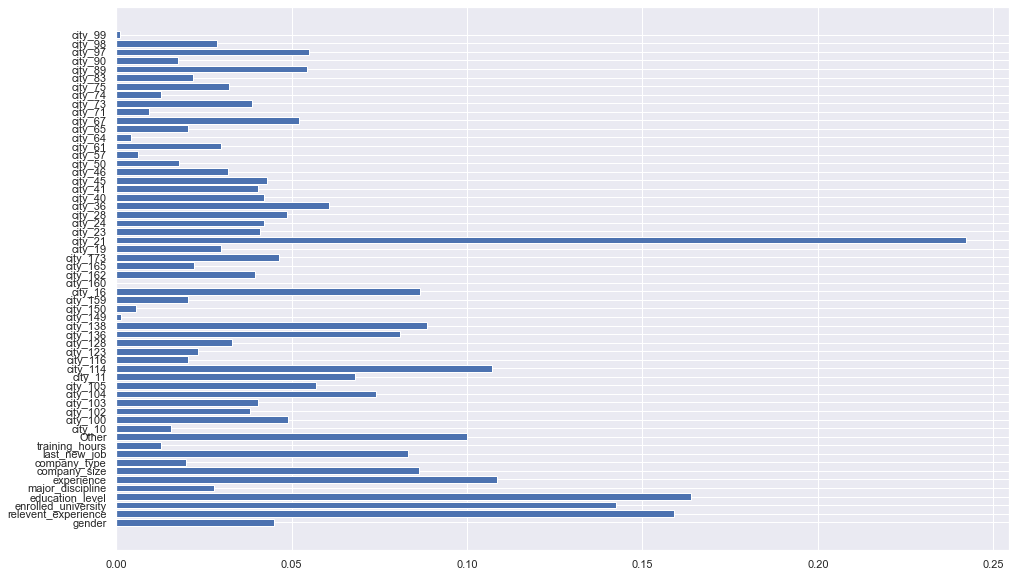

In [194]:
model = LogisticRegression()
model.fit(X_train, y_train)
len(model.coef_[0])

fig,ax = plt.subplots(figsize=(16,10))
    
plt.barh(df.drop('target',axis=1).columns.tolist(), abs(model.coef_[0]))

Next, Check feature importance for model: DecisionTree, RandomForest, GB, XGB, LightGB 
As their test score outperformed the other 4 models.

<BarContainer object of 58 artists>

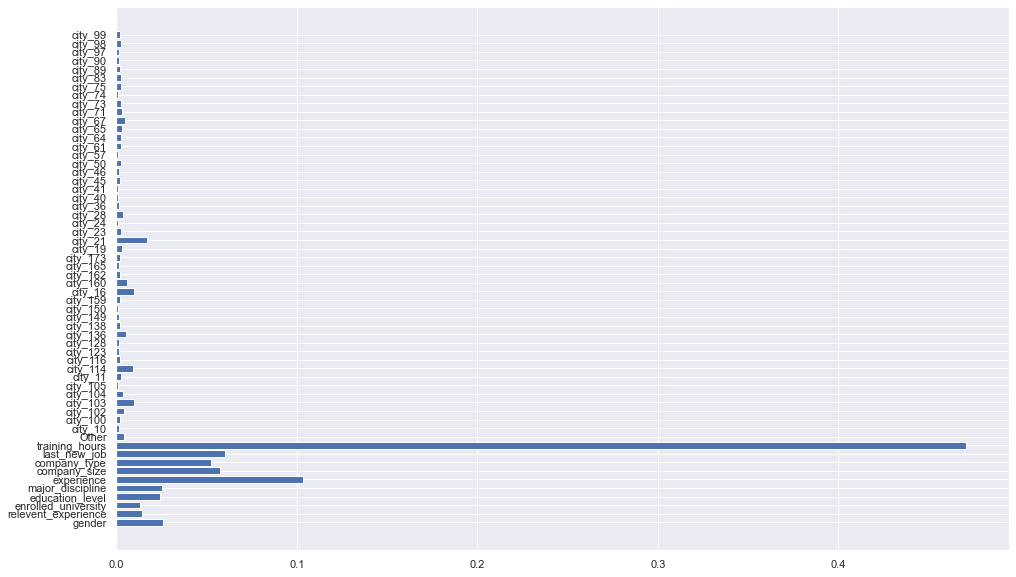

In [198]:
# feature importance for DecisionTree
model =  DecisionTreeClassifier(random_state=43)
model.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

<BarContainer object of 58 artists>

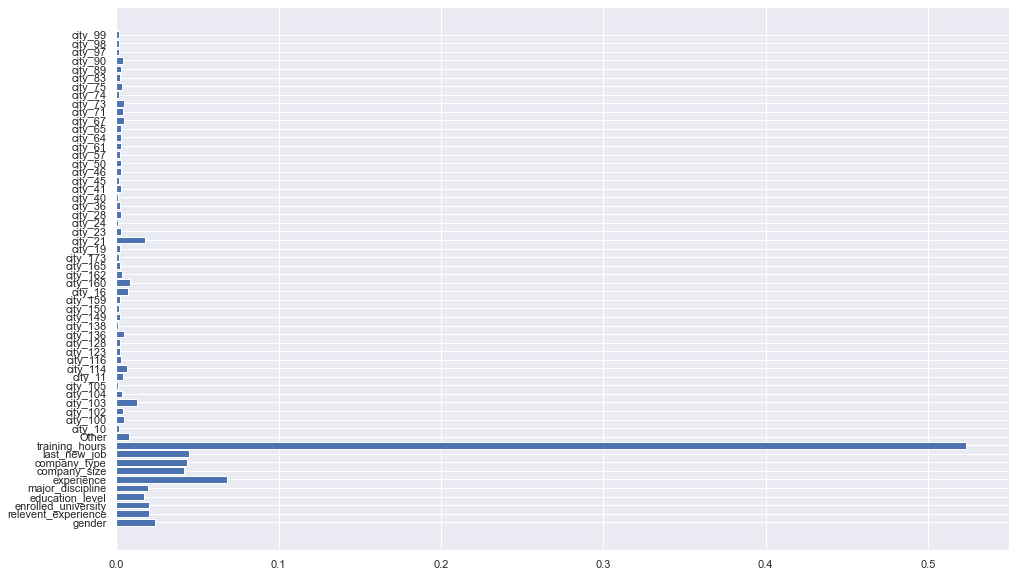

In [199]:
# feature importance for RandomForest
model = RandomForestClassifier(random_state=43)
model.fit(X_train, y_train)
fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

<BarContainer object of 58 artists>

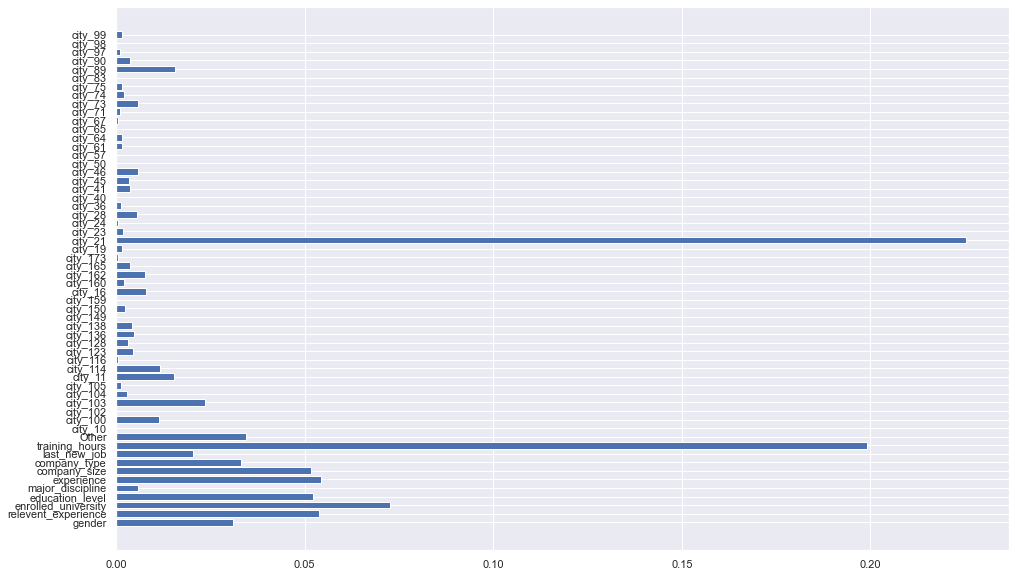

In [200]:
# feature importance for GB
model = GradientBoostingClassifier(random_state=43)
model.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

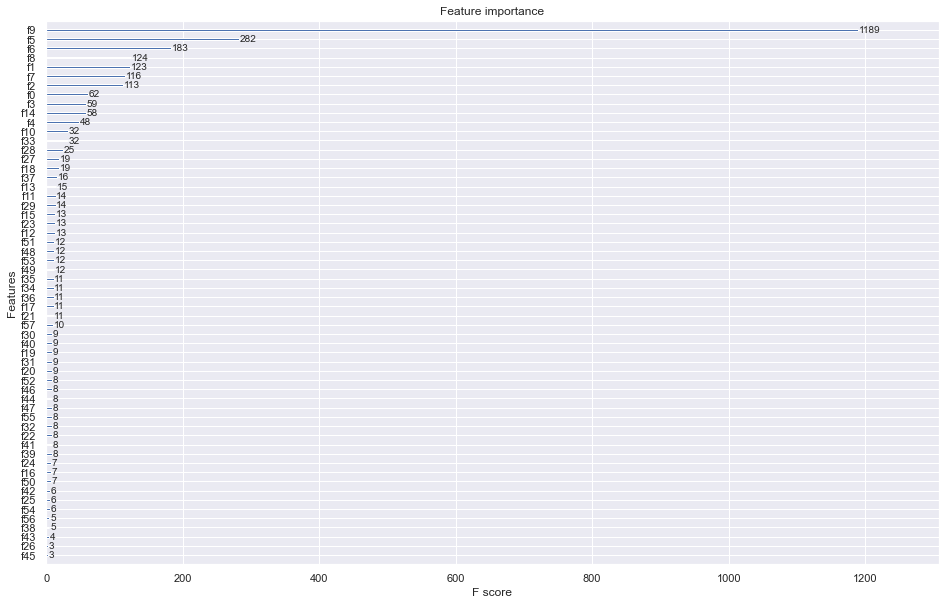

In [201]:
# feature importance for xgb
from xgboost import plot_importance
model = XGBClassifier(random_state=43)
model.fit(X_train,y_train)
fig,ax = plt.subplots(figsize=(16,10))
plot_importance(model,ax=ax)
plt.show()

In [203]:
df.columns[9]

'training_hours'

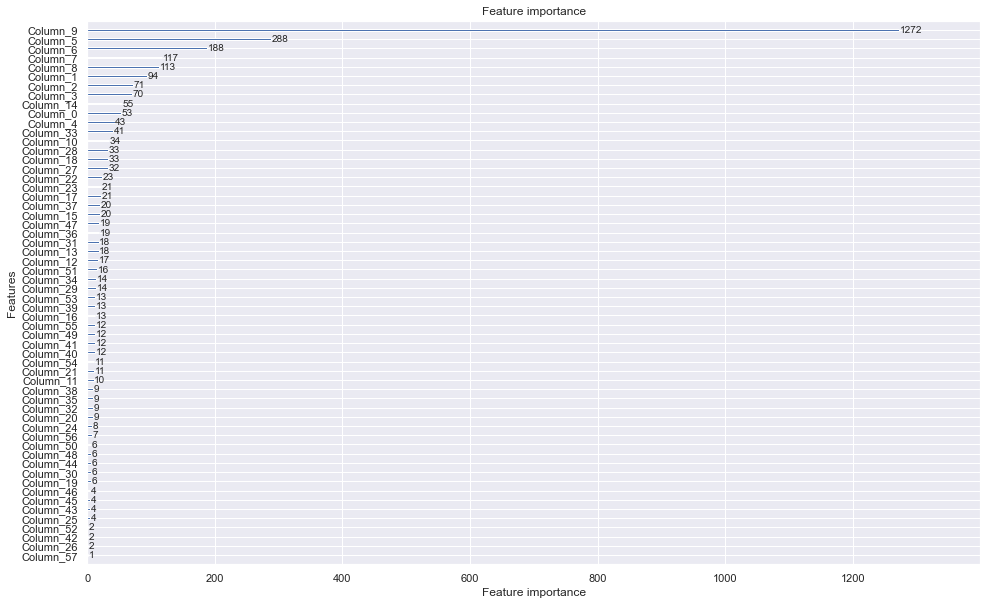

In [202]:
# # feature importance for lightgb
from lightgbm import plot_importance
model = lgb.LGBMClassifier(objective='binary',random_state=43)
model.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(16, 10))
plot_importance(model,ax=ax)
plt.show()

In [204]:
df.columns[9]

'training_hours'